# Downloading dataset
Attempting to download historical weather datasets by using [MSC GeoMet API](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/)
Data should include temperature, rain, wind, coordinates

In [1]:
# Modules importation
from datetime import date
import json
import math
from textwrap import fill

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import pyplot as plt, dates as mdates
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate

## Web Map Service (WMS)

In [2]:
from owslib.wms import WebMapService

In [3]:
# WMS service connection
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0',
                    timeout=300)

C:\Users\ethan\PycharmProjects\fire-guard\model\venv\Lib\site-packages\owslib\map\wms130.py:123: UserWarning: Content metadata for layer "Sea water potential temperature" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\ethan\PycharmProjects\fire-guard\model\venv\Lib\site-packages\owslib\map\wms130.py:123: UserWarning: Content metadata for layer "Sea water salinity" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\ethan\PycharmProjects\fire-guard\model\venv\Lib\site-packages\owslib\map\wms130.py:123: UserWarning: Content metadata for layer "Sea water velocity (X vector)" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)
C:\Users\ethan\PycharmProjects\fire-guard\model\venv\Lib\site-packages\owslib\map\wms130.py:123: UserWarning: Content met

Querying WMS from MSC by using Regional Ensemble Prediction System layer `REPS.DIAG.3_PRMM.ERGE5` : contains the probability that the quantity of precipitations will be equal or greater than 5mm

In [4]:
# Parameters
# Layer:
layer = 'REPS.DIAG.3_PRMM.ERGE5'
# Coordinates:
y, x = 49.288, -123.116
# Local time zone (in this exemple, the local time zone is UTC-07:00):
time_zone = -7

Available WMS layers

In [5]:
for item in list(wms.contents):
    print(item)

Canadian Weather
ALERTS
CURRENT_CONDITIONS
Lightning_2.5km_Density
METNOTES
Marine-Standard-Forecast-Zones
Public-Standard-Forecast-Zones
Air Quality
Air Quality Health Index (AQHI)
AQHI-OBS
Regional Air Quality Deterministic Prediction System (RAQDPS) [10 km]
Hotspots (seasonal)
FIREWORK.HOTSPOTS
WildfireHotspots
RAQDPS products
RAQDPS.EATM_PM2.5
RAQDPS.EATM_PM10
RAQDPS.EAtm_PM2.5-WildfireSmokePlume
RAQDPS.EAtm_PM10-WildfireSmokePlume
RAQDPS.SFC_NO
RAQDPS.SFC_NO2
RAQDPS.SFC_O3
RAQDPS.SFC_PM2.5
RAQDPS.SFC_PM10
RAQDPS.SFC_SO2
RAQDPS.Sfc_PM2.5-WildfireSmokePlume
RAQDPS.Sfc_PM10-WildfireSmokePlume
Regional Air Quality Deterministic Prediction System - FireWork (RAQDPS-FW) [10 km]
Cumulative Effects
Hotspots
RAQDPS-FW.CE_HOTSPOTS.2013
RAQDPS-FW.CE_HOTSPOTS.2014
RAQDPS-FW.CE_HOTSPOTS.2015
RAQDPS-FW.CE_HOTSPOTS.2016
RAQDPS-FW.CE_HOTSPOTS.2017
RAQDPS-FW.CE_HOTSPOTS.2018
RAQDPS-FW.CE_HOTSPOTS.2019
RAQDPS-FW.CE_HOTSPOTS.2020
RAQDPS-FW.CE_PM2.5-DIFF-MAvg
RAQDPS-FW.CE_PM2.5-DIFF-MAvg-DMax
RAQDPS-

In [6]:
wms['Canadian Weather'].title

'Canadian Weather'

In [7]:
wms['Canadian Weather'].queryable

1

In [8]:
[op.name for op in wms.operations]

['GetCapabilities',
 'GetMap',
 'GetFeatureInfo',
 'DescribeLayer',
 'GetLegendGraphic',
 'GetStyles']

# OCG API - Features

In [9]:
from owslib.ogcapi.features import Features

In [10]:
oafeat = Features("https://api.weather.gc.ca/")

In [11]:
# Parameters

# Coordinates of Chilliwack
lat = 49.162676
long = -121.958943

# Buffer size in kilometres
buffer = 100

# Start and end of the time period for which the data will be retrieved
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# ESPG code of the preferred projection to create the buffer
# NAD83 / Statistics Canada Lambert
projection = 3347

bbox = [
    long - buffer * 0.02,
    lat - buffer * 0.01,
    long + buffer * 0.02,
    lat + buffer * 0.01,
]

# Formatting of the selected time period
time_ = f"{start_date}/{end_date}"
time_

'2018-06-01/2018-08-31'

In [12]:
# Retrieval of hydrometric stations data
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Verification of the retrieved data
if "features" in station_data:
    station_json = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No hydrometric stations were found. Please verify the coordinates."
    )

In [13]:
print(station_json)

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "STATION_NAME": "CAPILANO RIVER ABOVE INTAKE",
                "IDENTIFIER": "08GA010",
                "STATION_NUMBER": "08GA010",
                "PROV_TERR_STATE_LOC": "BC",
                "STATUS_EN": "Active",
                "STATUS_FR": "En service",
                "CONTRIBUTOR_EN": "PRIVATE",
                "CONTRIBUTOR_FR": "SECTEUR PRIVE",
                "VERTICAL_DATUM": "ASSUMED DATUM NO. 1",
                "links": [
                    {
                        "type": "text/html",
                        "rel": "related",
                        "title": "Station Information for CAPILANO RIVER ABOVE INTAKE (08GA010)",
                        "href": "https://api.weather.gc.ca//collections/hydrometric-stations/items?STATION_NUMBER=08GA010&f=html"
                    },
                    {
                        "type": "applica

In [14]:
stations = []
for station in station_data['features'][:10]:
    print('Name: ' + station['properties']['STATION_NAME'])
    print('Station Number: ' + station['properties']['STATION_NUMBER'])
    print('Prov/Terr: ' + station['properties']['PROV_TERR_STATE_LOC'])
    print('Latitude: ' + str(station['geometry']['coordinates'][0]))
    print('Longitude: ' + str(station['geometry']['coordinates'][1]))
    print('=========================')
    stations.append(station['properties']['STATION_NUMBER'])

Name: CAPILANO RIVER ABOVE INTAKE
Station Number: 08GA010
Prov/Terr: BC
Latitude: -123.14584350585938
Longitude: 49.396240234375
Name: SQUAMISH RIVER NEAR BRACKENDALE
Station Number: 08GA022
Prov/Terr: BC
Latitude: -123.20316314697266
Longitude: 49.795021057128906
Name: CAPILANO RIVER ABOVE EASTCAP CREEK
Station Number: 08GA026
Prov/Terr: BC
Latitude: -123.11041259765624
Longitude: 49.45458984375
Name: SEYMOUR RIVER NEAR NORTH VANCOUVER
Station Number: 08GA030
Prov/Terr: BC
Latitude: -123.00212097167967
Longitude: 49.34197998046875
Name: CAPILANO RIVER AT CANYON
Station Number: 08GA031
Prov/Terr: BC
Latitude: -123.11094665527344
Longitude: 49.357948303222656
Name: CHEAKAMUS RIVER NEAR BRACKENDALE
Station Number: 08GA043
Prov/Terr: BC
Latitude: -123.15007781982422
Longitude: 49.8160285949707
Name: ROBERTS CREEK AT ROBERTS CREEK
Station Number: 08GA047
Prov/Terr: BC
Latitude: -123.64022064208984
Longitude: 49.42082977294922
Name: MACKAY CREEK AT MONTROYAL BOULEVARD
Station Number: 08GA06

In [15]:
len(station_data['features'])

88

In [16]:
stations

['08GA010',
 '08GA022',
 '08GA026',
 '08GA030',
 '08GA031',
 '08GA043',
 '08GA047',
 '08GA061',
 '08GA071',
 '08GA072']

In [19]:
# Retrieval of hydrometric data for each station

# Dictionary that will contain a data frame for each station with
# the historical daily mean water levels for the time period
hydrometric_data = {}

# List of stations with no water level data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Creation of a data frame if there is data for the chosen time period
    if hydro_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Creation of the data frame
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Adding the data frame to the hydrometric data dictionary
        if not historical_data_df["LEVEL"].isnull().all():
            # Removing any rows without water level data at the
            # end of the data frame
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Creating an index with the date in a datetime format
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Adding the data frame to the dictionary
            hydrometric_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing hydrometric stations without water level data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
# if not stations:
#     raise ValueError(
#         f"No water level data is available in the this {num_months}"
#         + " months period for the selected hydrometric stations."
#     )

In [20]:
historical_data_df

,STATION_NUMBER,STATION_NAME,LEVEL,LATITUDE,LONGITUDE
2018-06-01,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.449,50.07991,-123.035622
2018-06-02,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.420,50.07991,-123.035622
2018-06-03,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.423,50.07991,-123.035622
2018-06-04,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.415,50.07991,-123.035622
2018-06-05,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.382,50.07991,-123.035622
...,...,...,...,...,...
2018-08-27,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.215,50.07991,-123.035622
2018-08-28,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.202,50.07991,-123.035622
2018-08-29,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.222,50.07991,-123.035622
2018-08-30,08GA072,CHEAKAMUS RIVER ABOVE MILLAR CREEK,2.231,50.07991,-123.035622


In [24]:
hydrometric_data

{'08GA010':            STATION_NUMBER                 STATION_NAME  LEVEL  LATITUDE  \
 2018-06-01        08GA010  CAPILANO RIVER ABOVE INTAKE  1.187  49.39624   
 2018-06-02        08GA010  CAPILANO RIVER ABOVE INTAKE  1.164  49.39624   
 2018-06-03        08GA010  CAPILANO RIVER ABOVE INTAKE  1.231  49.39624   
 2018-06-04        08GA010  CAPILANO RIVER ABOVE INTAKE  1.277  49.39624   
 2018-06-05        08GA010  CAPILANO RIVER ABOVE INTAKE  1.231  49.39624   
 ...                   ...                          ...    ...       ...   
 2018-08-27        08GA010  CAPILANO RIVER ABOVE INTAKE  0.626  49.39624   
 2018-08-28        08GA010  CAPILANO RIVER ABOVE INTAKE  0.616  49.39624   
 2018-08-29        08GA010  CAPILANO RIVER ABOVE INTAKE  0.609  49.39624   
 2018-08-30        08GA010  CAPILANO RIVER ABOVE INTAKE  0.608  49.39624   
 2018-08-31        08GA010  CAPILANO RIVER ABOVE INTAKE  0.605  49.39624   
 
              LONGITUDE  
 2018-06-01 -123.145844  
 2018-06-02 -123.145844

C:\Users\ethan\AppData\Local\Temp\ipykernel_3796\1991423774.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hydrometric_data[station]["STATION_NAME"][0], station


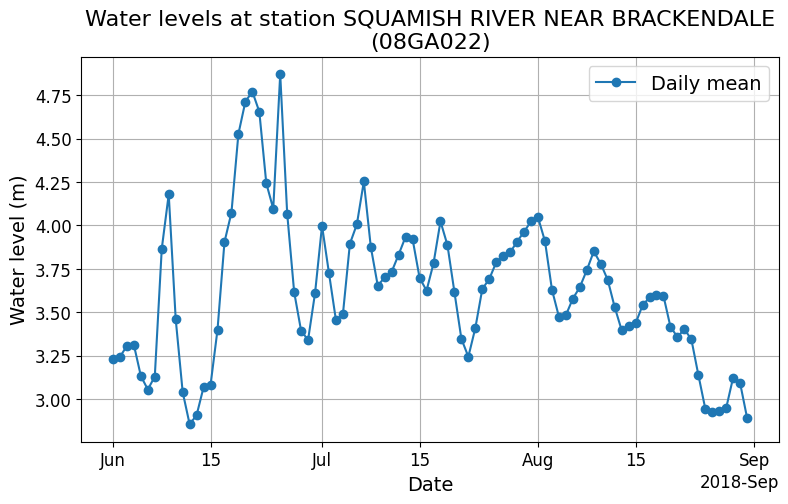

In [21]:
# Creation of an interactive plot with Matplotlib

# Hydrometric station to display on the plot
station_displayed_p = stations[1]

# Function to create a plot for the chosen hydrometric station
def interactive_plot(station):
    # Adjusting font and figure size
    params = {
        "legend.fontsize": "14",
        "figure.figsize": (9, 5),
        "axes.labelsize": "14",
        "axes.titlesize": "16",
        "xtick.labelsize": "12",
        "ytick.labelsize": "12",
    }
    plt.rcParams.update(params)

    # Creation of the plot
    fig, ax = plt.subplots()
    line, = plt.plot(
        hydrometric_data[station].index,
        hydrometric_data[station]["LEVEL"],
        marker="o",
        label="Daily mean",
    )
    plt.legend()
    plt.grid(True, which="both")
    ax.set_title(
        fill(
            "Water levels at station {} ({})".format(
                hydrometric_data[station]["STATION_NAME"][0], station
            ), 60
        )
    )
    ax.set_ylabel("Water level (m)")
    ax.set_xlabel("Date")

    # Modification of the x axis ticks and tick labels
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Creation of the annotations to display on hover
    annot = ax.annotate(
        "",
        xy=(0, 0),
        xytext=(-60, -40),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    return line, annot, ax, fig


# Choosing the hydrometric stations to create the plot
line, annot, ax, fig = interactive_plot(station_displayed_p)


# Updating the annotation with the data point information
def update_annot(ind):
    # Identifying the annotation to display
    x, y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])

    # Adding text to the annotation (date and water level)
    date_x = x[ind["ind"]][0]
    level_y = round(y[ind["ind"]][0], 2)
    text = "{}\nDaily mean: {} m".format(date_x, level_y)
    annot.set_text(text)

    # Setting annotation transparency
    annot.get_bbox_patch().set_alpha(0.8)


# Display of annotations on hover
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


# Adding the feature that displays annotations on hover
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()